In [2]:
# importing sys
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe
import pandas as pd
import numpy as np
import matplotlib 
import allel
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scipy
%matplotlib inline

## Getting frequencies of variants of interest!

TODO - exactl allele matching (currently using all ALTs summed, not OK!) but ok for these variants...

In [3]:
voiData = "../../resources/VariantsOfInterest.tsv"

In [4]:
## Read VOI data
muts = pd.read_csv(voiData, sep="\t")

## separate chrom and pos data and sort 
muts['chrom'] = muts['Location'].str.split(":").str.get(0)
muts['pos'] = muts['Location'].str.split(":").str.get(1).str.split("-").str.get(0)
muts = muts.sort_values(['chrom', 'pos'])
muts.head(2)

,Gene,GeneID,ALT,ALT2,Name,Location,chrom,pos
0,VGSC,AGAP004707,A,NaN,R254K,2L:2390177-2390177,2L,2390177
1,VGSC,AGAP004707,C,T,V402L,2L:2391228-2391228,2L,2391228


In [5]:
# Read metadata 
metadata = pd.read_csv("../../config/gaardian_metadata.tsv", sep="\t")

chroms = ['2L', '2R', '3R', '3L', 'X']
snps = {}
pos = {}

for chrom in chroms:
    # Load Arrays
    snps[chrom], pos[chrom] = probe.loadZarrArrays(genotypePath=f"../../resources/snp_genotypes/all/1244-VO-GH-YAWSON-VMF00149/{chrom}/calldata/GT", 
                                             positionsPath=f"../../resources/snp_genotypes/all/sites/{chrom}/variants/POS/",
                                             siteFilterPath=None, 
                                             haplotypes=False)
    
    

In [6]:
cohorts = probe.getCohorts(metadata, columns=['species_gambiae_coluzzii', 'location2'], minPopSize=5)
cohorts.head(2)

,species_gambiae_coluzzii,location2,indices,cohortText,cohortNoSpaceText,colour
0,coluzzii,Adansi Apagya.House.D,"[227, 228, 229, 230, 231, 232, 239, 240]",coluzzii | Adansi Apagya.House.D,coluzzii.AdansiApagya.House.D,#e41a1c
1,coluzzii,Annorkrom.House.A,"[264, 266, 267, 268, 280, 281, 282, 283, 284, ...",coluzzii | Annorkrom.House.A,coluzzii.Annorkrom.House.A,#e41a1c


In [23]:
for i, row in muts.iterrows():
    name = row['Name']
    chrom = row['chrom']
    voiPos = int(row['pos'])
    longName = chrom + ":"+ str(voiPos) + "  " + row['Gene'] + " | " + row['Name']

    VariantsOfInterest = pd.DataFrame([{'chrom':chrom, 'pos':voiPos, 'variant':name, 'name':longName}])

    bool_ = pos[chrom][:] == voiPos

    geno = snps[chrom].compress(bool_, axis=0)#.take(cohort['indices'], axis=1)
    ac = geno.count_alleles().compute()
    # if there are no ALTs lets add the zeros for the ALTs otherwise only REF count returned 
    aclength = ac.shape[1]
    acneeded = 4-aclength
    ac = np.append(ac, np.repeat(0, acneeded))
    metadata[name] = geno.to_n_alt().compute()[0]
    #get frequency and round
    #freqs = pd.DataFrame([ac/ac.sum().round(2)])
    #df2 = freqs.apply(pd.Series).rename(columns={0:'REF', 1:'ALT1', 2:'ALT2', 3:'ALT3'})
    #VariantsOfInterest[cohort['cohortText']] = df2.drop(columns=['REF']).sum(axis=1).round(2)

In [22]:
Dict = {}

allCohorts = {}

for idx, cohort in cohorts.iterrows():
    
    for i, row in muts.iterrows():
        name = row['Name']
        chrom = row['chrom']
        voiPos = int(row['pos'])
        longName = chrom + ":"+ str(voiPos) + "  " + row['Gene'] + " | " + row['Name']

        VariantsOfInterest = pd.DataFrame([{'chrom':chrom, 'pos':voiPos, 'variant':name, 'name':longName}])

        bool_ = pos[chrom][:] == voiPos
        
        geno = snps[chrom].compress(bool_, axis=0)#.take(cohort['indices'], axis=1)
        ac = geno.count_alleles().compute()
        # if there are no ALTs lets add the zeros for the ALTs otherwise only REF count returned 
        aclength = ac.shape[1]
        acneeded = 4-aclength
        ac = np.append(ac, np.repeat(0, acneeded))
        #get frequency and round
        #freqs = pd.DataFrame([ac/ac.sum().round(2)])
        #df2 = freqs.apply(pd.Series).rename(columns={0:'REF', 1:'ALT1', 2:'ALT2', 3:'ALT3'})
        #VariantsOfInterest[cohort['cohortText']] = df2.drop(columns=['REF']).sum(axis=1).round(2)
        
        Dict[name] = VariantsOfInterest
    
    allCohorts[idx] = pd.concat(Dict)

In [12]:
VariantsOfInterest = pd.concat(allCohorts, axis=1).T.drop_duplicates().T.droplevel(level=0, axis=1)
VariantsOfInterest = VariantsOfInterest.drop(columns=['chrom', 'pos', 'variant']).set_index('name').astype("float64").round(2)
VariantsOfInterest.to_csv("../../results/variantsOfInterest/VOI.AlleleFrequencies.tsv", sep="\t")
plotRectangular(VariantsOfInterest, path="../../results/variantsOfInterest/heatmap.png", figsize=[14,14], xlab='cohort')

### LD

In [17]:
import malariagen_data
ag3 = malariagen_data.Ag3("gs://vo_agam_release/")
cohorts = {
    'mali': "sample_set == 'AG1000G-ML-A' and species == 'gambiae'",
}
eff = ag3.snp_effects("AGAP004707-RD")
muts.query("Gene == 'VGSC'")
df = eff[eff['aa_change'].isin(muts['Name'])]
df
alts = zarr.open_array("../../resources/snp_genotypes/all/sites/2L/variants/ALT/")[:]

In [291]:
l = {}

for idx, row, in df.iterrows():
    
    contig = row['contig']
    pos_bool = pos[contig].locate_intersection([row['position']])[0]
    myAlts = alts[pos_bool].astype(str)
   # print(row['aa_change'])
    altidx = np.where(myAlts == row['alt_allele'])[1][0]
    
    geno = snps[contig].compress(pos_bool, axis=0)
    ac = geno.count_alleles().compute()
    bial = ac.is_biallelic()
        
    if bial == False & ac.is_variant() == True:
        possibleGenos = np.unique(geno) # get uniuqe possible genotypes 
        mask = np.isin(possibleGenos, altidx+1) # boolean mask for the desired geno
        myAltIdx = (np.where(mask)[0]+1)[0] # get desired geno idx
        otherAltIDX = possibleGenos[~mask][-1] # get second ALT geno idx
        geno = np.where(geno==otherAltIDX, 0, geno).compute() #replace second ALT genos with 0
    
    l[idx] = geno
    

In [296]:
geno = np.concatenate([l[x] for x in l], 0)
geno = allel.GenotypeArray(geno).to_n_alt()

In [297]:
r = allel.rogers_huff_r(geno)
from scipy.spatial.distance import squareform
r = squareform(r ** 2)

r.shape

r = pd.DataFrame(r).set_index(df['aa_change'])
r.columns = df['aa_change']

In [306]:
r = r.astype("float64").round(2)

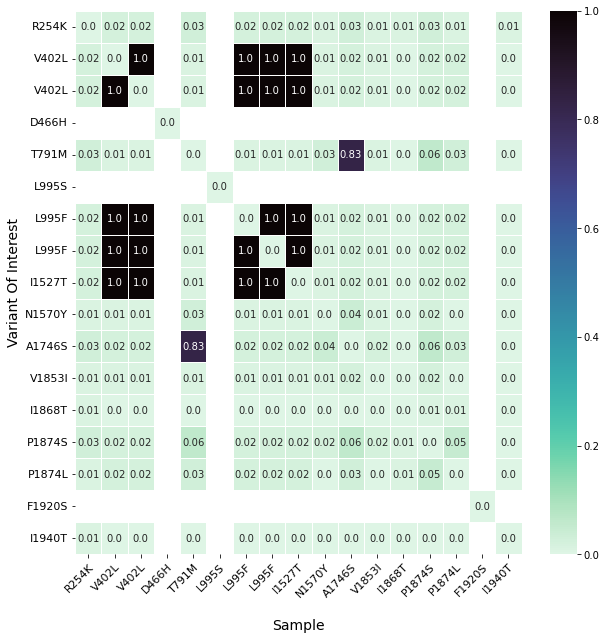

In [307]:
plotRectangular(r, annot=True, path="LDplot.png", cmap="mako_r")

In [20]:
muts['name'] =  muts['chrom'] + ":"+ str(muts['pos']) + "  " + ['Gene'] + " | " + row['Name']

,Gene,GeneID,ALT,ALT2,Name,Location,chrom,pos
0,VGSC,AGAP004707,C,T,V402L,2L:2391228-2391228,2L,2391228
1,VGSC,AGAP004707,T,NaN,T791M,2L:2416980-2416980,2L,2416980
2,VGSC,AGAP004707,C,NaN,L995S,2L:2422651-2422651,2L,2422651
3,VGSC,AGAP004707,T,NaN,L995F,2L:2422652-2422652,2L,2422652
4,VGSC,AGAP004707,C,NaN,I1527T,2L:2429617-2429617,2L,2429617
5,VGSC,AGAP004707,T,NaN,N1570Y,2L:2429745-2429745,2L,2429745
6,VGSC,AGAP004707,T,NaN,P1874S,2L:2430880-2430880,2L,2430880
7,VGSC,AGAP004707,T,NaN,P1874L,2L:2430881-2430881,2L,2430881
14,Rdl,AGAP006028,T,NaN,A296S,2L:25429235-25429235,2L,25429235
13,Rdl,AGAP006028,G,NaN,A296G,2L:25429236-25429236,2L,25429236


## 2D interpolation and contour plot

In [8]:
def interpolateRBF(df, voiname):
    
    coords = df[['longitude', 'latitude']].to_numpy()
    
    #Get data range
    x_min, x_max = df['longitude'].min(), df['longitude'].max()
    y_min, y_max = df['latitude'].min(), df['latitude'].max()

    #Create an array with new coordinates in the acquired data range
    new_x_coord = np.linspace(x_min, x_max, 100)
    new_y_coord = np.linspace(y_min, y_max, 100)

    # x,Create grid array of y
    xx, yy = np.meshgrid(new_x_coord, new_y_coord)
    dense_grid = np.stack([xx.ravel(), yy.ravel()], -1)

    #Known x,y coordinate,Get that value
    knew_xy_coord = df[['longitude', 'latitude']].values
    knew_values = df['AlleleFrequency'].values

    #Interpolate data between coordinates, method='nearest', 'linear' or 'cubic'
    interpolator = scipy.interpolate.RBFInterpolator(coords, df['AlleleFrequency'])
    result = interpolator(dense_grid).reshape(xx.shape)

    #graph display
    fig = plt.figure(figsize=[12,10])
    ax = fig.add_subplot(111)
    cs = ax.contourf(xx, yy, result, cmap='jet')
    fig.colorbar(cs)
    plt.title(voiname)
    plt.ylim(5.93,6.42)
    plt.xlim(-1.98,-1.35)
    plt.scatter(coords[:,0], coords[:,1], color="black", alpha=0.6)
    for x_, y_, name in zip(coords[:,0], coords[:,1], df['AlleleFrequency']):
        plt.text(x_+0.01, y_, name, fontsize=15, color="black")
    plt.show()

In [37]:
df.iloc[:, 4:].melt(id_vars=['name'], var_name='cohort', value_name='AlleleFrequency')

,name,cohort,AlleleFrequency
0,2L:2390177 VGSC | R254K,coluzzii | Adansi Apagya,0.10
1,2L:2391228 VGSC | V402L,coluzzii | Adansi Apagya,0.17
2,2L:2399997 VGSC | D466H,coluzzii | Adansi Apagya,0.00
3,2L:2416980 VGSC | T791M,coluzzii | Adansi Apagya,0.03
4,2L:2422651 VGSC | L995S,coluzzii | Adansi Apagya,0.00
...,...,...,...
391,2L:25635973 CYP4J5 | L43F,gambiae | New Edubiase,0.37
392,2R:28497967 CYP6P4 | I236M,gambiae | New Edubiase,0.00
393,2R:3492074 ACE1 | G280S,gambiae | New Edubiase,0.28
394,3R:28598062 GSTe2 | L119V,gambiae | New Edubiase,0.80


In [89]:
import scipy
import matplotlib.pyplot as plt

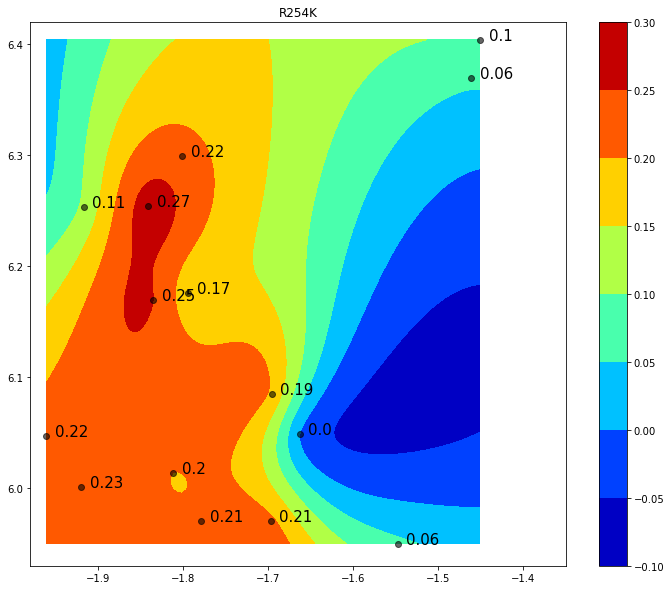

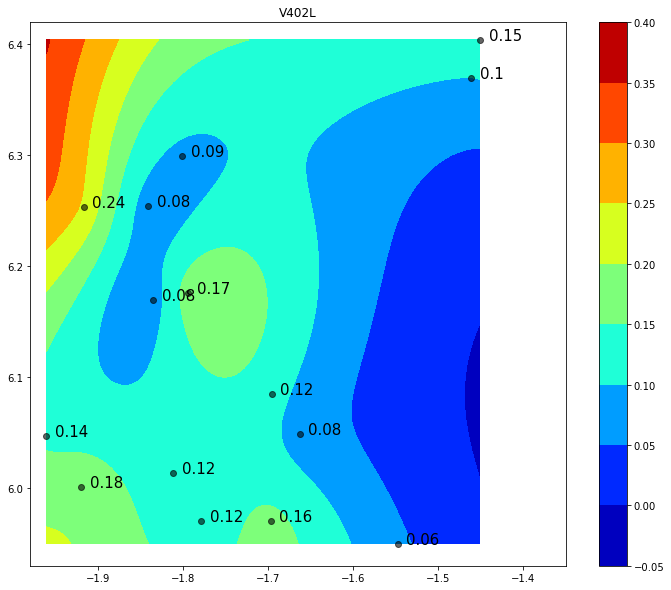

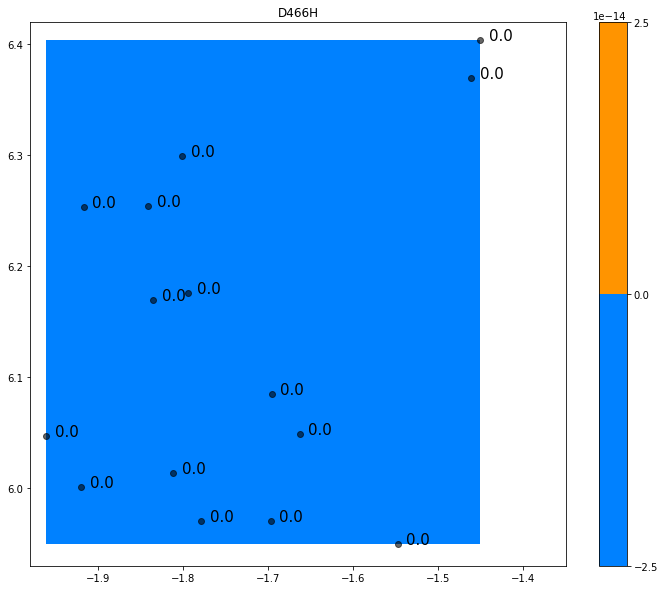

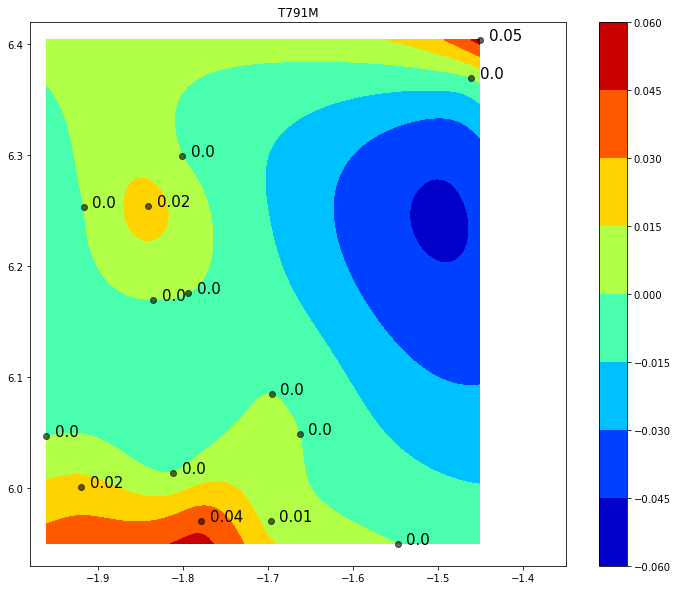

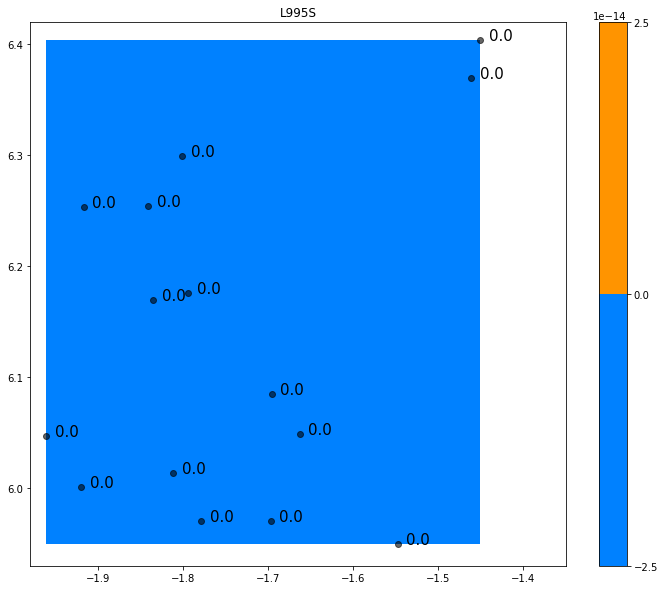

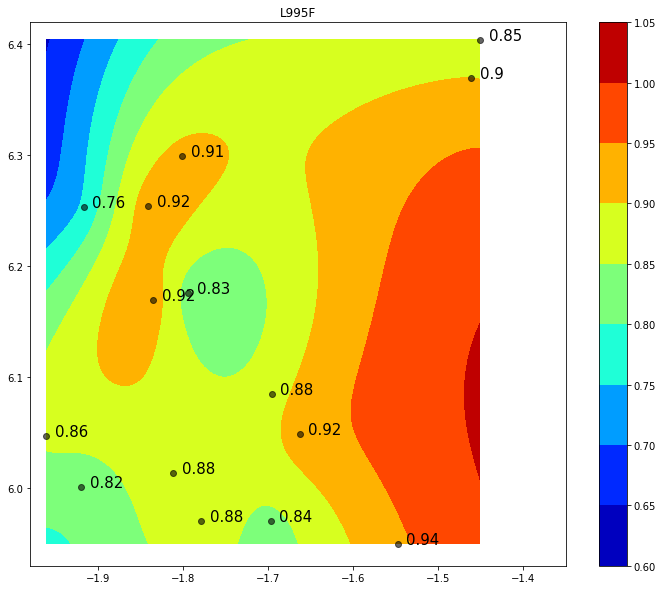

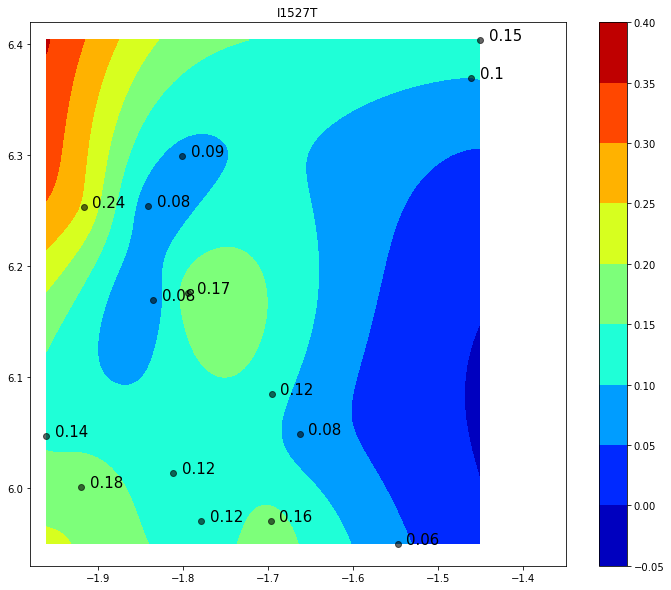

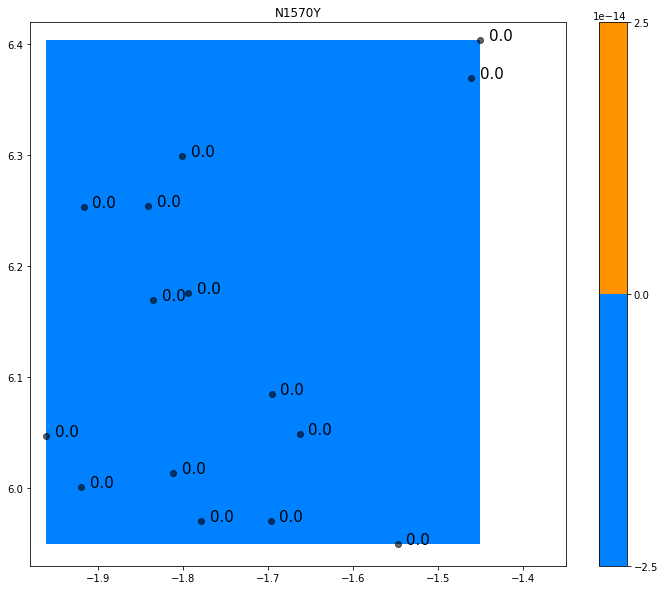

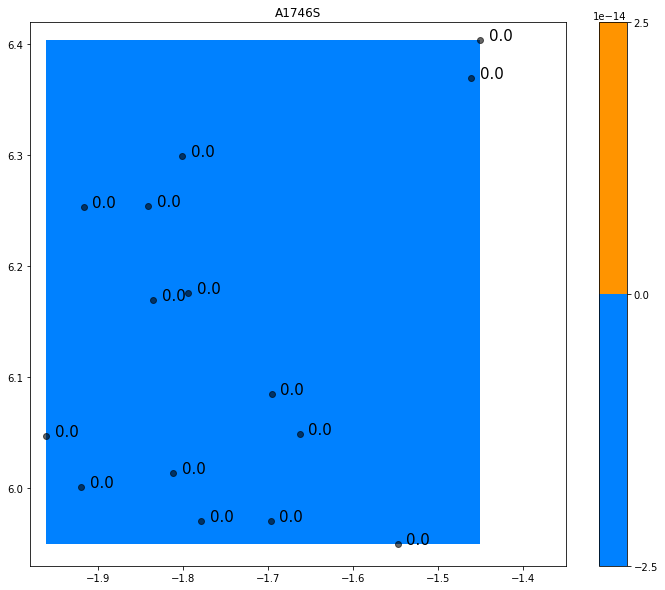

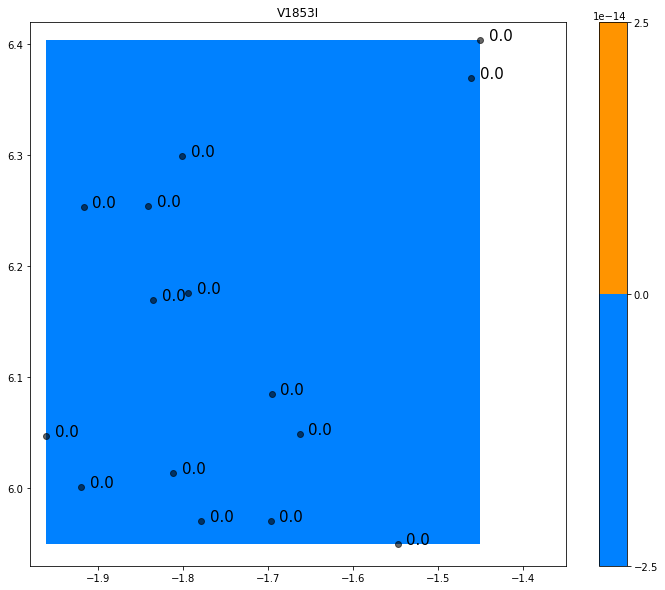

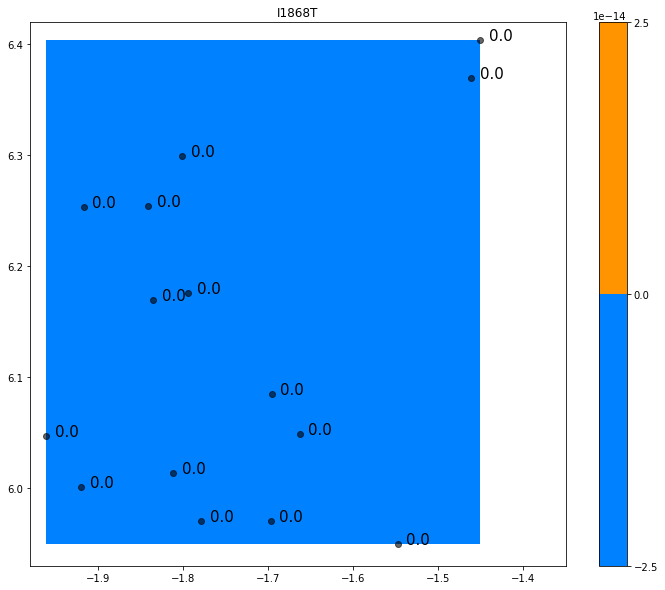

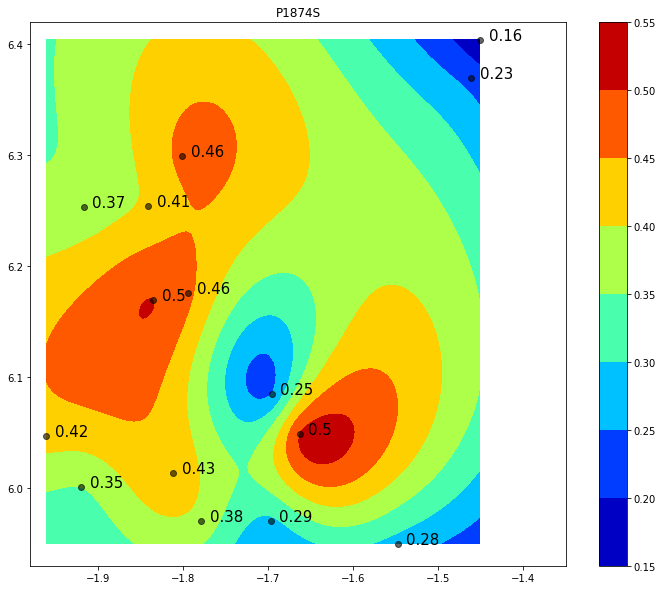

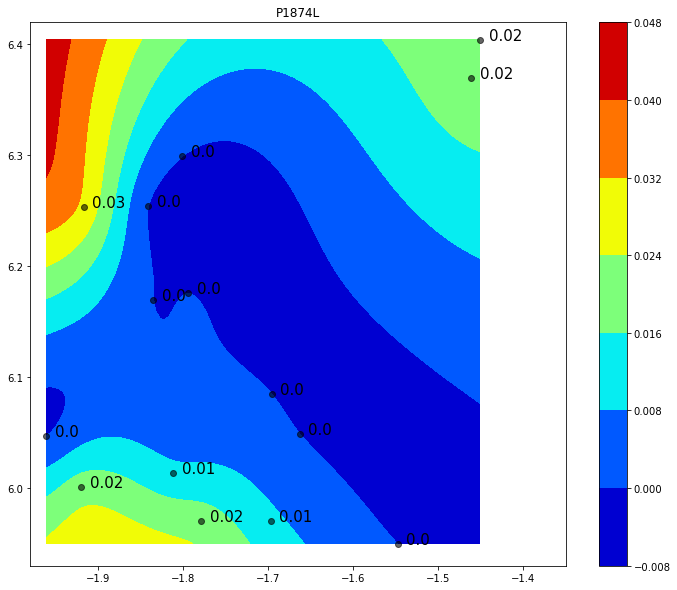

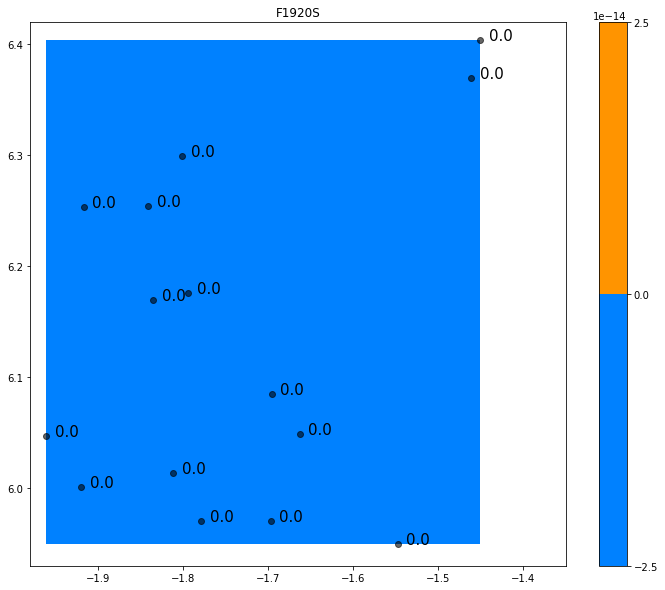

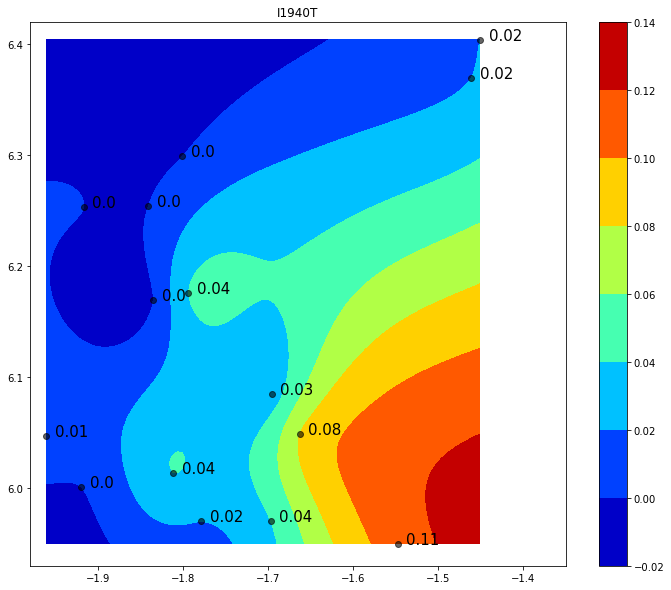

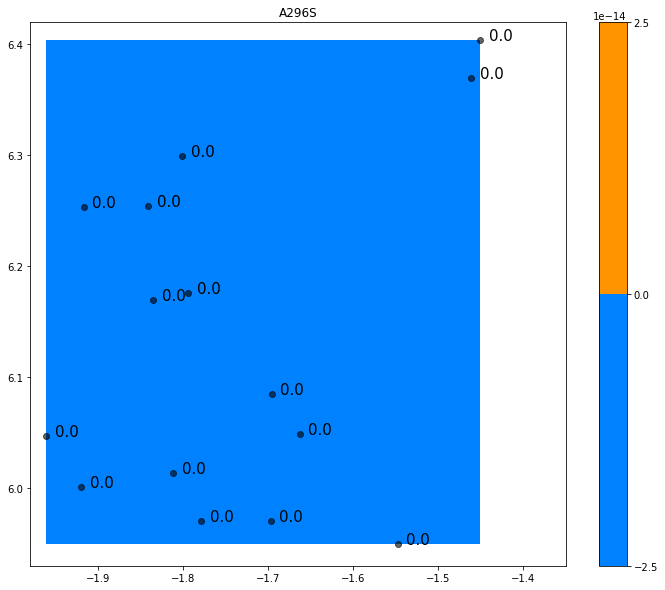

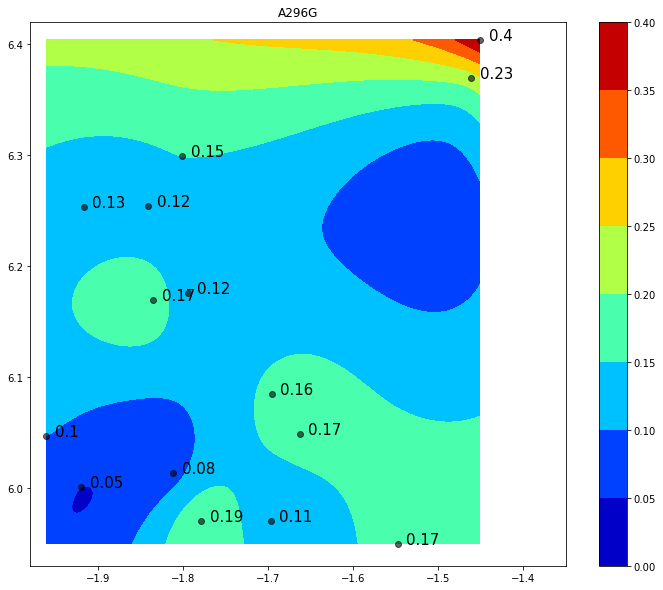

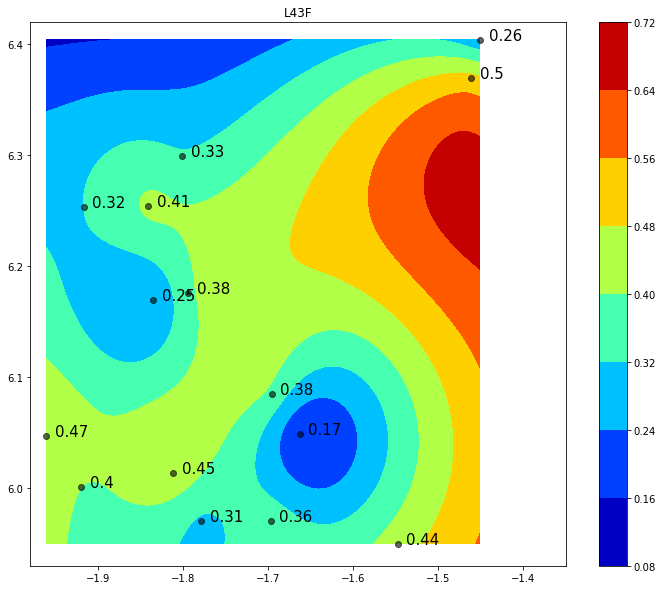

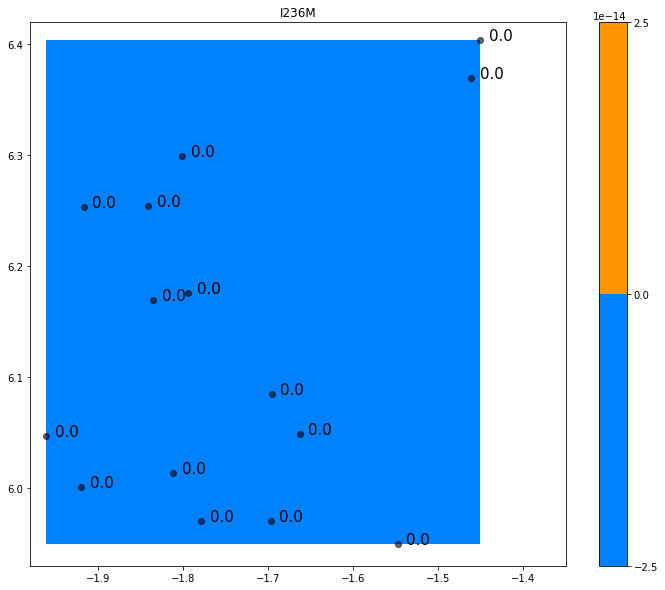

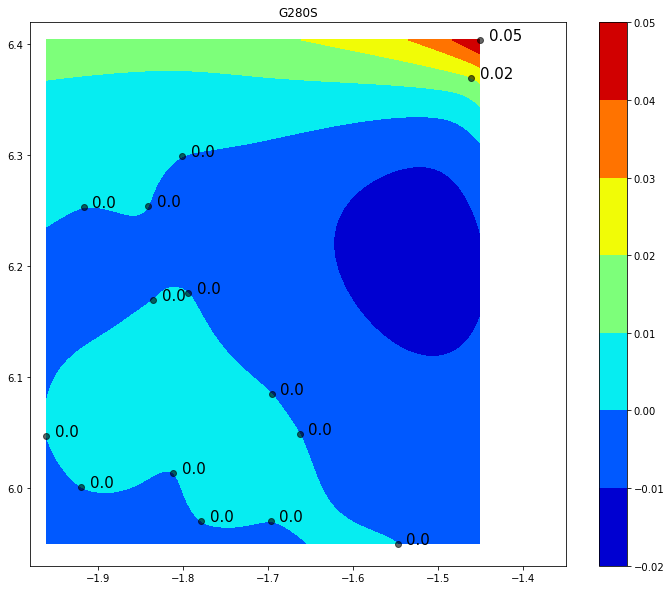

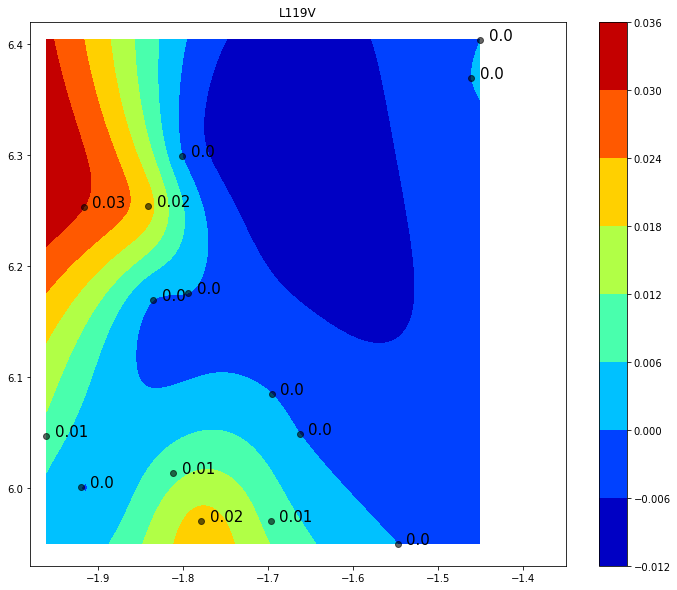

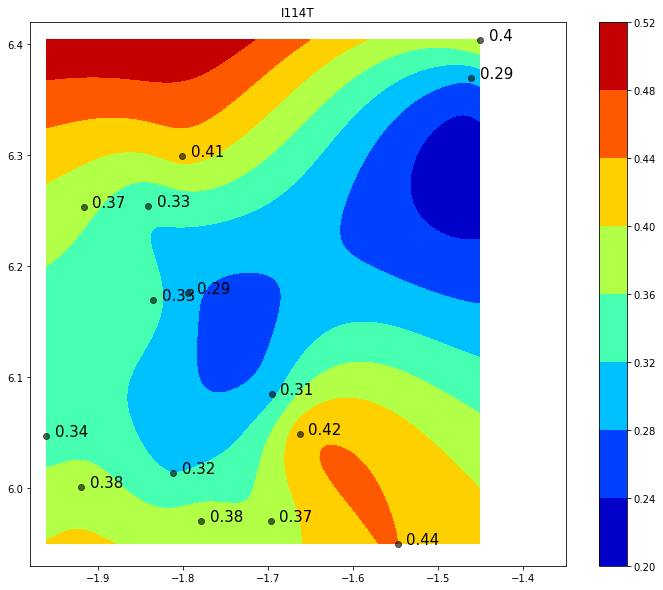

In [90]:
df = pd.read_csv(f"../../results/variantsOfInterest/VOI.ag3_gaardian.frequencies.tsv", sep="\t", index_col=0)

af_long = df.iloc[:, 4:].melt(id_vars=['name'], var_name='cohort', value_name='AlleleFrequency')
af_long['aa_change'] = af_long['name'].str.split("|").str.get(-1).str.replace(" ", "")
af_long['location'] = af_long['cohort'].str.split("|").str.get(-1).str.replace(" ", "")
af_long = af_long.merge(metadata[['location', 'latitude', 'longitude']].drop_duplicates('location'))

for voi in muts['Name']:

    af_voi = af_long.query("aa_change == @voi")
    
    interpolateRBF(af_voi, voi)

Get the per-sample alleles for all Variants of interest

In [7]:
gndict = {}
for chrom in chroms:
    print(chrom)
    poslist = muts.query("chrom == @chrom")['pos'].to_numpy().astype(int)
    poslist = np.sort(poslist)
    print(poslist)
    bool_ = pos[chrom].locate_intersection(poslist.astype(int))[0]
    print("intersecting")
    print("Intersections found")
    if bool_.sum() == 0:
        continue
    print("compressing...")
    gndict[chrom] = np.array(snps[chrom].compress(bool_, axis=0))

geno = np.concatenate([gndict[x] for x in gndict], 0)
geno = allel.GenotypeArray(geno)

2L
[ 2390177  2391228  2399997  2416980  2422651  2422652  2429617  2429745
  2430424  2430817  2430863  2430880  2430881  2431019  2431079 25429235
 25429236 25635973]
intersecting
Intersections found
compressing...
2R
[ 3492074 28497967]
intersecting
Intersections found
compressing...
3R
[28598062 28598166]
intersecting
Intersections found
compressing...
3L
[]
intersecting
Intersections found
X
[]
intersecting
Intersections found


In [8]:
np.save("../../results/variantsOfInterest/voi.genotypeArray.npy", geno)

In [95]:
for voi in muts['Name']:

    af_voi = af_long.query("aa_change == @voi")

In [96]:

af_voi

,name,cohort,AlleleFrequency,aa_change,location,latitude,longitude
21,3R:28598166 GSTe2 | I114T,coluzzii | Adansi-Krom,0.33,I114T,Adansi-Krom,6.170,-1.835
43,3R:28598166 GSTe2 | I114T,coluzzii | Ankaako,0.29,I114T,Ankaako,6.176,-1.794
65,3R:28598166 GSTe2 | I114T,coluzzii | Annorkrom,0.37,I114T,Annorkrom,5.970,-1.697
87,3R:28598166 GSTe2 | I114T,coluzzii | Domenase,0.34,I114T,Domenase,6.047,-1.961
109,3R:28598166 GSTe2 | I114T,coluzzii | Kente,0.41,I114T,Kente,6.299,-1.801
131,3R:28598166 GSTe2 | I114T,coluzzii | Kokotro,0.29,I114T,Kokotro,6.370,-1.461
153,3R:28598166 GSTe2 | I114T,coluzzii | Koniyaw,0.40,I114T,Koniyaw,6.404,-1.451
175,3R:28598166 GSTe2 | I114T,coluzzii | Mprakyire,0.44,I114T,Mprakyire,5.950,-1.548
197,3R:28598166 GSTe2 | I114T,coluzzii | Nkotumso,0.38,I114T,Nkotumso,6.001,-1.920
219,3R:28598166 GSTe2 | I114T,coluzzii | Odumto,0.33,I114T,Odumto,6.254,-1.841
